In [ ]:
N=50010
type_of_network = 3
from covid_simulation import * 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [1]:
type_of_network_dict = {1: 'Erdős-Rényi graph', 2: 'Barabási–Albert graph', 3: 'Watts–Strogatz small-world graph'}

type_of_network_dict[type_of_network]
data_dir = os.path.join('../data','data_' + str(type_of_network)+'_'+ str(N))

if not os.path.exists(data_dir): 
    os.mkdir(data_dir)

NameError: name 'type_of_network' is not defined

In [ ]:
# create empty graph
if type_of_network == 1:  
    G = nx.fast_gnp_random_graph(n=N, p=mean_num_of_neighbors/(N-1))
elif type_of_network ==2 : 
    G = nx.barabasi_albert_graph(n=N,m=mean_num_of_neighbors)
elif type_of_network == 3 : 
    G = nx.watts_strogatz_graph(n=N,k=mean_num_of_neighbors, p=0.5)

# Set all nodes to 'S' status
for node in G.nodes: 
    G.nodes[node]['status'] = 'S'

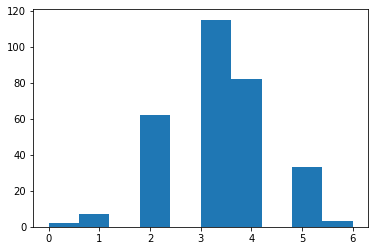

0 3.2467105263157894


In [8]:
# Group into families
family_size_list=sorted([int(np.round(x)) for x in np.random.normal(loc=mean_family_size, scale=1.0, size=int(N/mean_family_size))], reverse=True)
#family_size_list=[int(np.ceil(x)) for x in np.random.normal(loc=mean_family_size, scale=1.0, size=int(1.1 * N/mean_family_size))]
plt.hist(family_size_list)
plt.show()
print(min(family_size_list), np.mean(family_size_list))

In [10]:

for group_index, family_size in enumerate(family_size_list): 
    seed = find_free_node(G, min_neighbors=family_size)
    if not seed: 
        print('no free node was found for family size of {}'.format(family_size))
        continue 
        
    neigbors=find_free_neighbors(G,seed)   
    if neigbors: 
        G.nodes[seed]['group'] = group_index
        selected_nodes=list(np.random.choice(neigbors, size=family_size, replace=False))
        selected_nodes.append(seed)    
        for node in selected_nodes: 
            if 'group' in G.nodes[node]: 
                #print('!!!! group was already y assigned !!!!')
                pass
            G.nodes[node]['group'] = group_index

no free node was found for family size of 4
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for family size of 3
no free node was found for famil

In [6]:
ll= []
for f in set([y['group'] for x, y in G.nodes(data=True) if 'group' in y]): 
    ll.append(len(select_per_attr(G,'group', f)))
plt.hist(ll)
print(np.mean(ll))

NameError: name 'plt' is not defined

In [11]:
nx.write_gpickle(G, os.path.join(data_dir,'G.p'))


In [13]:
# Assign age per distribution
p=[x['precentage'] for k, x in infection_by_age.items()]
p /= np.sum(p)

# normal dist
age_stats=[(np.mean(x['age_group']), np.diff(x['age_group'])[0]/2) for k, x in infection_by_age.items()]

age_distribution_model=MixtureModel( submodels=[stats.norm(x[0], x[1]) for x in age_stats], p=p)

age_samples = list(np.random.choice([x for x in age_distribution_model.rvs(round(1.01 * N), ) if (x>0) & (x<100)], size=round(1.001 * N)))


In [14]:
infection_by_age.items()

dict_items([(1, {'age_group': [0, 14], 'precentage': 13.6, 'p': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1}, 'asymptomatic_rate': 0.8, 'death_rate': 0.0}), (2, {'age_group': [15, 24], 'precentage': 9.61, 'p': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1}, 'asymptomatic_rate': 0.6, 'death_rate': 0.0015}), (3, {'age_group': [25, 54], 'precentage': 41.82, 'p': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1}, 'asymptomatic_rate': 0.4, 'death_rate': 0.01}), (4, {'age_group': [55, 100], 'precentage': 34.98, 'p': {1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1}, 'asymptomatic_rate': 0.2, 'death_rate': 0.24})])

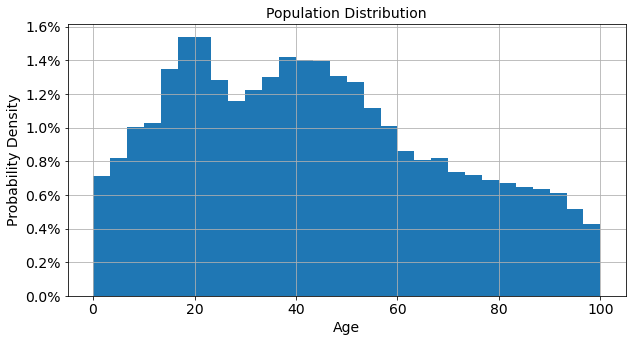

In [15]:
# plot population dist
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(age_samples, bins=30, density=True)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.grid()
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.title('Population Distribution', fontsize=14)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1))
plt.savefig(os.path.join(data_dir,'Population Distribution.eps'), format='eps')
#plt.show()

In [10]:
people_per_age={1:[], 2:[], 3:[], 4:[]}
for n in age_samples:
    age_group=find_age_group(n)
    people_per_age[age_group].append(n)

print('people_per_age: ')
print([(x, len(people_per_age[x])/N) for x in range(1,5)])  
print('====================================')  

people_per_age: 
[(1, 0.299), (2, 0.307), (3, 0.225), (4, 0.17)]


In [11]:
# assign age for families
family_list=set([y['group'] for node, y in G.nodes(data=True) if 'group' in y])
for group_idx in tqdm(family_list): 
    family=select_per_attr(G, 'group', group_idx)
    family_len=len(family)
    if family_len > 2 : 
        for idx, age in enumerate(age_draw(age_samples, 2, age_range = [20,60])): 
            y=family.pop(0) # take the first element from famility list and assgin random age
            G.nodes[y]['age'] = age
            #print('({0}):{1}->{2}'.format(group_idx,y,age))
        
        for idx, age in enumerate(age_draw(age_samples, family_len - 2, age_range = [0,20])): 
            y=family.pop(0) # take the first element from famility list and assgin random age
            G.nodes[y]['age'] = age        
            #print('({0}):{1}->{2}'.format(group_idx,y,age))
            
    elif family_len == 2: 
        for idx, age in enumerate(age_draw(age_samples, family_len, age_range = [55,100])): 
            y=family.pop(0) # take the first element from famility list and assgin random age
            G.nodes[y]['age'] = age  
            #print('({0}):{1}->{2}'.format(group_idx,y,age))
    else: 
        for idx, age in enumerate(age_draw(age_samples, family_len, age_range = [20,100])): 
            y=family.pop(0) # take the first element from famility list and assgin random age
            G.nodes[y]['age'] = age            
            #print('({0}):{1}->{2}'.format(group_idx,y,age))




100%|██████████| 8801/8801 [1:08:39<00:00,  2.14it/s]


In [12]:
# assign age for the remains: 
non_aged_list=[node for node, y in G.nodes(data=True) if 'age' not in y]
for node in non_aged_list:    
    age=age_draw(age_samples, 1)[0]
    G.nodes[node]['age']=age

In [107]:
for ind, node in G.nodes(data=True): 
    if 'age' not in node: 
        print(ind, node)

In [108]:
for ind, node in G.nodes(data=True): 
    if 'group' not in node: 
        print(ind, node)

17 {'status': 'S', 'age': 90.92094648027802}
30 {'status': 'S', 'age': 94.38037153219095}
47 {'status': 'S', 'age': 88.17360086274167}
57 {'status': 'S', 'age': 89.63153681539313}
77 {'status': 'S', 'age': 91.7632300078454}
87 {'status': 'S', 'age': 98.71777424997491}
89 {'status': 'S', 'age': 86.79117325405302}
128 {'status': 'S', 'age': 89.54151961115828}
141 {'status': 'S', 'age': 91.91981697738237}
149 {'status': 'S', 'age': 83.46010885407037}
151 {'status': 'S', 'age': 86.51601880053173}
159 {'status': 'S', 'age': 84.83381767990946}
174 {'status': 'S', 'age': 79.95071367115817}
217 {'status': 'S', 'age': 98.2446490355112}
253 {'status': 'S', 'age': 83.54573740268039}
308 {'status': 'S', 'age': 95.50440493512073}
313 {'status': 'S', 'age': 95.50440493512073}
322 {'status': 'S', 'age': 80.73560797671188}
327 {'status': 'S', 'age': 95.26023001438853}
347 {'status': 'S', 'age': 89.93799400964332}
358 {'status': 'S', 'age': 96.67112229329857}
389 {'status': 'S', 'age': 98.2966143895746

In [13]:
# save into pickle
nx.write_gpickle(G, os.path.join(data_dir,'G_aged.p'))

In [7]:
## Set equi-age connections
G=nx.read_gpickle(os.path.join(data_dir,'G_aged.p'))
nodes_list=list(range(N))
random.shuffle(nodes_list) # make sure changes are done randomlly
for node in nodes_list: 
    match_neighbors_per_age_group(G, node)

# save into pickle
nx.write_gpickle(G, os.path.join(data_dir,'G_equi_aged.p'))

not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough neighbors
not enough ne

In [8]:
## Set equi-age for eldery group connections
G=nx.read_gpickle(os.path.join(data_dir,'G_aged.p'))

for node in G.nodes(): 
    if find_age_group(G.nodes[node]['age']) == 4:  
        rematch_neighbors(G, node)

# save into pickle
nx.write_gpickle(G, os.path.join(data_dir,'G_aged_eldery_grouped.p'))


In [5]:
def plot_dist_per_age(ax, data, age_group): 
    sns.distplot(data, kde=False, fit=stats.norm, axlabel='# Connections', norm_hist=True, 
    ax=ax)
    (mu, sigma) = stats.norm.fit(data)
    ax.set_title('Age Group: {}'.format(age_group))

    # place a text box in upper left in axes coords
    textstr = "$\mu=${0:.2g}\n $\sigma=${1:.2f})".format(mu, sigma)
    ax.text(0.68, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=1.0))
    ax.locator_params(axis='x', nbins=5)
    ax.set_xlim([0, 40])



G=nx.read_gpickle(os.path.join(data_dir,'G_aged.p'))
degree_per_age={1:[], 2:[], 3:[], 4:[]}
for n,y in G.nodes(data=True): 
    age_group=find_age_group(y['age'])
    degree_per_age[age_group].append(len(list(nx.neighbors(G, n))))



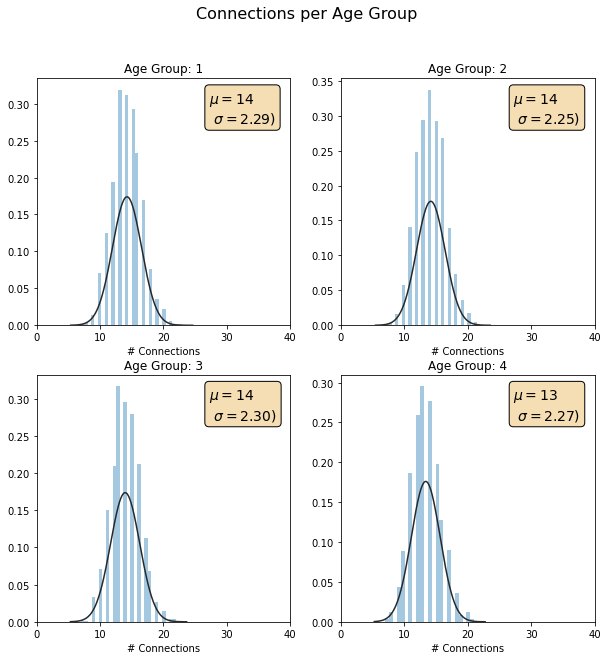

In [6]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
plot_dist_per_age(axes[0,0], degree_per_age[1], '1')
plot_dist_per_age(axes[0,1], degree_per_age[2], '2')
plot_dist_per_age(axes[1,0], degree_per_age[3], '3')
plot_dist_per_age(axes[1,1], degree_per_age[4], '4')
fig.suptitle('Connections per Age Group', fontsize=16)
#plt.savefig(os.path.join(data_dir,'Connections per Age Group.eps'), format='eps')
plt.show()